## Data preparation

For tuning the ML models and augmentation parameters, we need to split the train set into a train set and validation set. If we were to use temporal info later, we need to separate storms instead of images.



In [1]:
from separate_val_data import separate_val_files 

In [2]:
train_dir = 'data/train'
val_dir = 'data/val' 
# val dictionary should not exist, otherwise, it would raise error to avoid runnig it multiple times.
val_fr = 0.2

separate_val_files(train_dir, val_dir, val_fr)

ValueError: data/val already exist.

## Directory structure

```
project
|____data
|    |____train
|    |     |___abc_001.jpg
|    |     |___abc_002.jpg
|    |
|    |____val
|    |     |___acc_001.jpg
|    |     |___acc_002.jpg
|    |
|    |____training_set_features.csv
|    |____training_set_labels.csv
|____separate_val_data.py
|____image_batch_gen.py
|____Hurricane.ipynb
```

## Make batch

In [3]:
import os
from os.path import join
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [4]:
class ImgBatchGen(tf.keras.utils.Sequence):
    def __init__(self, img_dir, ground_truth_file, batch_size=32):
        self.bacth_size = batch_size
        files = os.listdir(img_dir)
        label_df = pd.read_csv(ground_truth_file, index_col=0, header=0)
        self.files = [(join(img_dir, f), label_df.loc[f[:7], 'wind_speed']) for f in files if f.endswith('.jpg')]
        random.shuffle(self.files)
        
    def __len__(self):
        return int(np.floor(len(self.files)/self.bacth_size))

    def __getitem__(self, index):
        images, labels = [], []

        for file, label in self.files[index*self.bacth_size:(index+1)*self.bacth_size]:
            img = cv2.imread(file, 0)
            if img is None:
                continue

            images.append(img)
            labels.append(label)

        x = np.array(images)[:, :, :, np.newaxis].astype(np.float32) / 255.0
        y = np.array(labels).astype(np.float32)

        return x, y
    

In [5]:
train_batchgen = ImgBatchGen('data/train', 'data/training_set_labels.csv', 32)
val_batchgen = ImgBatchGen('data/val', 'data/training_set_labels.csv', 32)

(32, 366, 366, 1) (32,)
61.0


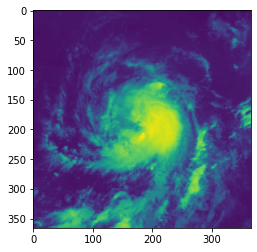

In [6]:
train_x, train_y = train_batchgen[0]
print(train_x.shape, train_y.shape)
plt.imshow(train_x[0])
print(train_y[0])

## Make Model

In [7]:
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

In [8]:
model = Sequential()
model.add(Conv2D(64, (7,7), padding='same', activation='relu', input_shape=(366, 366, 1)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

In [9]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 366, 366, 64)      3200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 366, 366, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 183, 183, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 183, 183, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 183, 183, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 91, 91, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        3

In [10]:
## Train

In [ ]:
history = model.fit(val_batchgen, epochs = 100, verbose=1, validation_data=val_batchgen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 422 steps, validate for 422 steps
Epoch 1/100
 80/422 [====>.........................] - ETA: 2:05 - loss: 1669.6752 - mse: 1669.6750 - mae: 29.5580 - mape: 64.8822